# Chess Model Testing & Preprocessing

This notebook tests your trained chess recognition model on new screenshots with preprocessing to handle:
- Arrows and highlights
- Different piece styles
- Various board themes

## Prerequisites

1. Trained model: `models/ensemble_medium.keras`
2. Test images in: `data/screenshots/`

## Step 1: Imports and Configuration

In [2]:
import numpy as np
import os
import cv2
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.util.shape import view_as_blocks
from skimage import io, transform
import keras
import tensorflow as tf
import warnings
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

# Configuration
SQUARE_SIZE = 40
MODEL_PATH = 'models/ensemble_medium.keras'
SCREENSHOTS_PATH = 'data/screenshots'

# Piece symbols
piece_symbols = 'prbnkqPRBNKQ'

print("✅ Imports loaded successfully")

2026-01-30 01:32:42.244204: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 01:32:42.244921: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 01:32:42.333046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-30 01:32:44.361630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

✅ Imports loaded successfully


## Step 2: FEN Encoding/Decoding Functions

In [3]:
def fen_from_onehot(one_hot):
    """Convert one-hot encoded array (8 x 8) back to FEN string."""
    output = ''
    for j in range(8):
        for i in range(8):
            if one_hot[j][i] == 12:
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if j != 7:
            output += '-'
    
    # Compress consecutive spaces into numbers
    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))
    
    return output

def simplified_fen_to_standard_fen(simple_fen, 
                                   active_color='w',
                                   castling='KQkq',
                                   en_passant='-',
                                   halfmove=0,
                                   fullmove=1):
    """Convert simplified FEN to standard FEN format."""
    board_fen = simple_fen.replace('-', '/')
    standard_fen = f"{board_fen} {active_color} {castling} {en_passant} {halfmove} {fullmove}"
    return standard_fen

def create_lichess_link(simple_fen, active_color='w', castling='KQkq', 
                       en_passant='-', halfmove=0, fullmove=1):
    """Create a Lichess analysis link from FEN."""
    standard_fen = simplified_fen_to_standard_fen(simple_fen, active_color, castling, 
                                                   en_passant, halfmove, fullmove)
    lichess_fen = standard_fen.replace(' ', '_')
    return f"https://lichess.org/editor/{lichess_fen}"

def create_lichess_link_simple(simple_fen):
    """Create Lichess link with default game state."""
    return create_lichess_link(simple_fen)

print("✅ FEN functions defined")

✅ FEN functions defined


## Step 3: Preprocessing Functions

These functions remove arrows, highlights, and enhance contrast.

In [4]:
def remove_arrows_and_highlights(image):
    """
    Remove yellow/orange arrows and highlights from chess board.
    
    Args:
        image: numpy array (H, W, 3) or (H, W, 4) in RGB/RGBA
    
    Returns:
        Cleaned image (numpy array)
    """
    # Handle RGBA
    if image.shape[-1] == 4:
        image = image[:, :, :3]
    
    # Ensure float range [0, 1]
    if image.max() > 1.0:
        image = image.astype(np.float32) / 255.0
    
    # Convert to uint8 for OpenCV
    image_uint8 = (image * 255).astype(np.uint8)
    
    # Convert RGB to BGR for OpenCV
    image_bgr = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)
    
    # Convert to HSV for better color detection
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    
    # Define yellow/orange color ranges (HSV)
    # Lower yellow (highlights)
    lower_yellow1 = np.array([20, 100, 100])
    upper_yellow1 = np.array([40, 255, 255])
    
    # Upper yellow/orange (arrows)
    lower_yellow2 = np.array([10, 100, 100])
    upper_yellow2 = np.array([25, 255, 255])
    
    # Create masks
    mask1 = cv2.inRange(hsv, lower_yellow1, upper_yellow1)
    mask2 = cv2.inRange(hsv, lower_yellow2, upper_yellow2)
    mask = cv2.bitwise_or(mask1, mask2)
    
    # Dilate mask slightly to catch edges
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    
    # Inpaint to fill the masked areas
    cleaned_bgr = cv2.inpaint(image_bgr, mask, 3, cv2.INPAINT_TELEA)
    
    # Convert back to RGB
    cleaned_rgb = cv2.cvtColor(cleaned_bgr, cv2.COLOR_BGR2RGB)
    
    # Convert back to float [0, 1]
    cleaned = cleaned_rgb.astype(np.float32) / 255.0
    
    return cleaned

def enhance_contrast(image):
    """
    Enhance contrast to make pieces clearer.
    """
    # Convert to uint8 if needed
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    # Convert RGB to BGR for OpenCV
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Convert to LAB color space
    lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    
    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_bgr = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    
    # Convert back to RGB
    enhanced_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)
    
    return enhanced_rgb.astype(np.float32) / 255.0

def preprocess_chess_image(image_path):
    """
    Complete preprocessing pipeline for chess board images.
    
    Args:
        image_path: Path to chess board image
    
    Returns:
        Preprocessed image ready for model
    """
    # Load image
    image = io.imread(image_path)
    
    # Remove arrows and highlights
    cleaned = remove_arrows_and_highlights(image)
    
    # Enhance contrast
    enhanced = enhance_contrast(cleaned)
    
    return enhanced

print("✅ Preprocessing functions defined")

✅ Preprocessing functions defined


## Step 4: Image Processing Function

In [5]:
def process_image_with_preprocessing(img_path, use_preprocessing=True):
    """
    Load, preprocess (optional), and split chess board image into 64 squares.
    
    Args:
        img_path: Path to image
        use_preprocessing: Whether to apply arrow removal and contrast enhancement
    
    Returns:
        64 square images (64, SQUARE_SIZE, SQUARE_SIZE, 3)
    """
    downsample_size = SQUARE_SIZE * 8  # 320 pixels
    
    if use_preprocessing:
        # Preprocess the image first
        img_read = preprocess_chess_image(img_path)
    else:
        # Load without preprocessing
        img_read = io.imread(img_path)
        # Handle RGBA
        if img_read.shape[-1] == 4:
            img_read = img_read[:, :, :3]
        # Normalize to [0, 1]
        if img_read.max() > 1.0:
            img_read = img_read.astype(np.float32) / 255.0
    
    # Resize
    img_read = transform.resize(img_read, (downsample_size, downsample_size), mode='constant')
    
    # Split into 8x8 grid
    tiles = view_as_blocks(img_read, block_shape=(SQUARE_SIZE, SQUARE_SIZE, 3))
    tiles = tiles.squeeze(axis=2)
    
    return tiles.reshape(64, SQUARE_SIZE, SQUARE_SIZE, 3)

print("✅ Image processing function defined")

✅ Image processing function defined


## Step 5: Load Model

Load your trained ensemble model.

In [6]:
# Define weighted loss function (needed for loading model)
def weighted_categorical_crossentropy(weights):
    """Weighted loss function to handle class imbalance."""
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, axis=-1)
        return loss
    
    return loss

# Load the ensemble model
print(f"Loading model from: {MODEL_PATH}")

weights = np.array([
    1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
    1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
    1/(64-10)
])

# Note: Ensemble models may not need custom_objects, try without first
try:
    ensemble_model = keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded successfully (without custom_objects)")
except:
    # If that fails, try with custom_objects
    ensemble_model = keras.models.load_model(
        MODEL_PATH,
        custom_objects={'loss': weighted_categorical_crossentropy(weights)}
    )
    print("✅ Model loaded successfully (with custom_objects)")

print(f"Model input shape: {ensemble_model.input_shape}")
print(f"Model output shape: {ensemble_model.output_shape}")

Loading model from: models/ensemble_medium.keras


E0000 00:00:1769736785.572967  832368 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769736785.584339  832368 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ Model loaded successfully (with custom_objects)
Model input shape: (None, 40, 40, 3)
Model output shape: (None, 13)


## Step 6: Visualize Preprocessing

Test the preprocessing on a sample image.

Found 2 screenshot(s):
  1. chess_2.png
  2. chess_test_fen.png

Using: chess_2.png


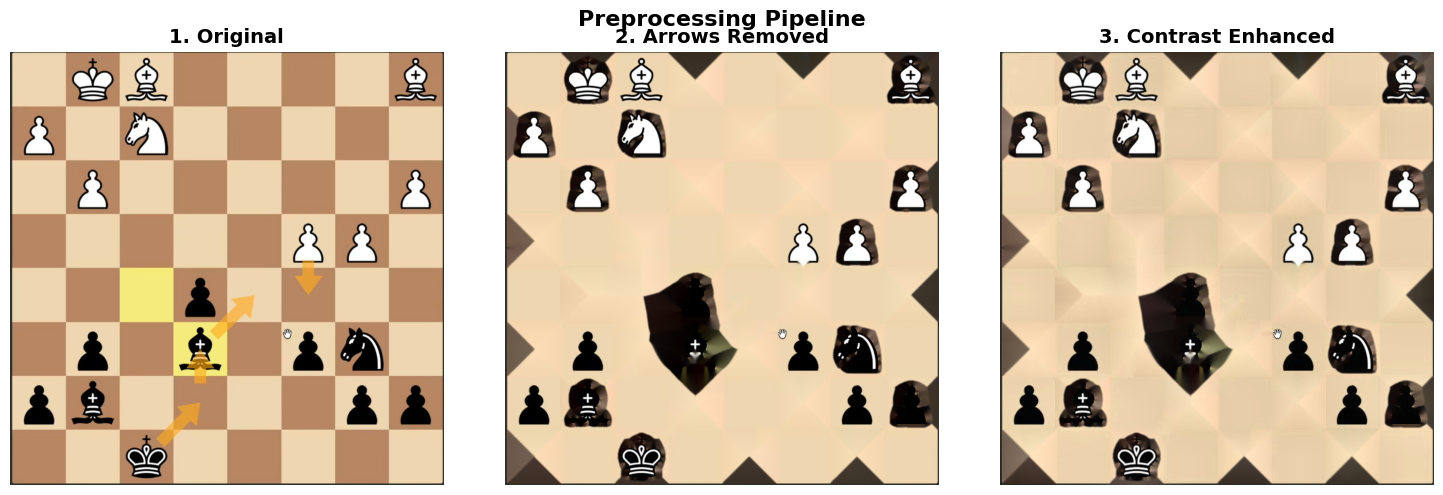


✅ Preprocessing visualization complete!


In [7]:
# List available screenshots
screenshot_files = [f for f in os.listdir(SCREENSHOTS_PATH) if f.endswith(('.png', '.jpg', '.jpeg'))]

if len(screenshot_files) == 0:
    print("❌ No screenshots found in data/screenshots/")
    print("Please add some chess board screenshots to test!")
else:
    print(f"Found {len(screenshot_files)} screenshot(s):")
    for i, f in enumerate(screenshot_files):
        print(f"  {i+1}. {f}")
    
    # Use the first one for visualization
    test_image_path = os.path.join(SCREENSHOTS_PATH, screenshot_files[0])
    print(f"\nUsing: {screenshot_files[0]}")
    
    # Load and process
    original = io.imread(test_image_path)
    cleaned = remove_arrows_and_highlights(original)
    enhanced = enhance_contrast(cleaned)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original)
    axes[0].set_title("1. Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(cleaned)
    axes[1].set_title("2. Arrows Removed", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(enhanced)
    axes[2].set_title("3. Contrast Enhanced", fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle("Preprocessing Pipeline", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Preprocessing visualization complete!")

## Step 7: Predict Without Preprocessing

First, let's see how the model performs WITHOUT preprocessing.

In [8]:
if len(screenshot_files) > 0:
    test_image_path = os.path.join(SCREENSHOTS_PATH, screenshot_files[0])
    
    print("="*60)
    print("PREDICTION WITHOUT PREPROCESSING")
    print("="*60)
    
    # Process without preprocessing
    squares = process_image_with_preprocessing(test_image_path, use_preprocessing=False)
    
    # Predict
    predictions = ensemble_model.predict(squares, verbose=0)
    predicted_classes = predictions.argmax(axis=1)
    
    # Convert to FEN
    predicted_board = predicted_classes.reshape(8, 8)
    predicted_fen = fen_from_onehot(predicted_board)
    
    # Calculate confidence (divide by 3 for ensemble)
    avg_confidence = (predictions.max(axis=1) / 3).mean()
    min_confidence = (predictions.max(axis=1) / 3).min()
    
    # Display results
    print(f"\n🎯 Predicted FEN:")
    print(predicted_fen)
    print(f"\n📊 Confidence:")
    print(f"  Average: {avg_confidence*100:.2f}%")
    print(f"  Minimum: {min_confidence*100:.2f}%")
    
    # Create links
    standard_fen = simplified_fen_to_standard_fen(predicted_fen)
    lichess_link = create_lichess_link_simple(predicted_fen)
    
    print(f"\n🔗 Links:")
    print(f"Standard FEN: {standard_fen}")
    print(f"Lichess: {lichess_link}")
    print("="*60)
else:
    print("⚠️ Add screenshots to data/screenshots/ folder first!")

PREDICTION WITHOUT PREPROCESSING

🎯 Predicted FEN:
1KB4B-P1N5-1P5P-5PP1-3p4-1p1b1pn1-nb4pp-2k5

📊 Confidence:
  Average: 99.11%
  Minimum: 42.89%

🔗 Links:
Standard FEN: 1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5 w KQkq - 0 1
Lichess: https://lichess.org/editor/1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5_w_KQkq_-_0_1


## Step 8: Predict WITH Preprocessing

Now let's see if preprocessing improves the results!

PREDICTION WITH PREPROCESSING

🎯 Predicted FEN:
1KB4B-P1N5-1P5P-5PP1-2Pn3P-1pNb1pn1-nq4pq-p1k1p1p1

📊 Confidence:
  Average: 95.79%
  Minimum: 40.09%

🔗 Links:
Standard FEN: 1KB4B/P1N5/1P5P/5PP1/2Pn3P/1pNb1pn1/nq4pq/p1k1p1p1 w KQkq - 0 1
Lichess: https://lichess.org/editor/1KB4B/P1N5/1P5P/5PP1/2Pn3P/1pNb1pn1/nq4pq/p1k1p1p1_w_KQkq_-_0_1


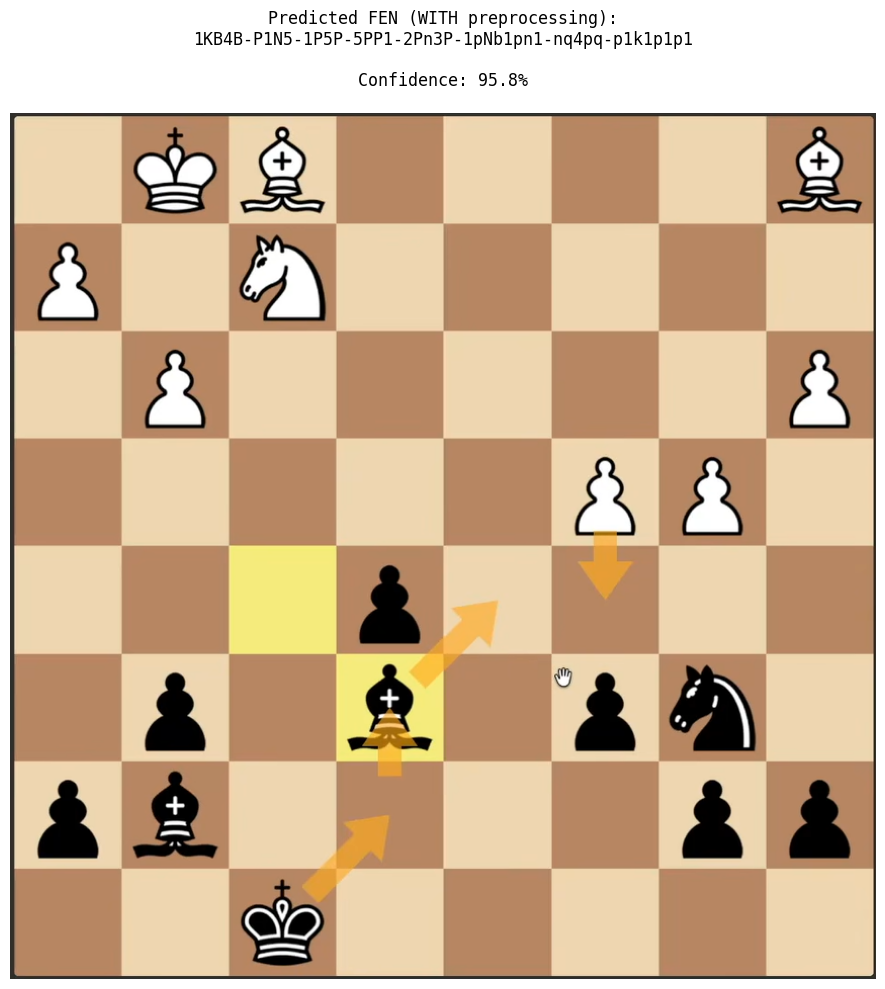

In [9]:
if len(screenshot_files) > 0:
    test_image_path = os.path.join(SCREENSHOTS_PATH, screenshot_files[0])
    
    print("="*60)
    print("PREDICTION WITH PREPROCESSING")
    print("="*60)
    
    # Process WITH preprocessing
    squares = process_image_with_preprocessing(test_image_path, use_preprocessing=True)
    
    # Predict
    predictions = ensemble_model.predict(squares, verbose=0)
    predicted_classes = predictions.argmax(axis=1)
    
    # Convert to FEN
    predicted_board = predicted_classes.reshape(8, 8)
    predicted_fen = fen_from_onehot(predicted_board)
    
    # Calculate confidence (divide by 3 for ensemble)
    avg_confidence = (predictions.max(axis=1) / 3).mean()
    min_confidence = (predictions.max(axis=1) / 3).min()
    
    # Display results
    print(f"\n🎯 Predicted FEN:")
    print(predicted_fen)
    print(f"\n📊 Confidence:")
    print(f"  Average: {avg_confidence*100:.2f}%")
    print(f"  Minimum: {min_confidence*100:.2f}%")
    
    # Create links
    standard_fen = simplified_fen_to_standard_fen(predicted_fen)
    lichess_link = create_lichess_link_simple(predicted_fen)
    
    print(f"\n🔗 Links:")
    print(f"Standard FEN: {standard_fen}")
    print(f"Lichess: {lichess_link}")
    print("="*60)
    
    # Visualize the prediction
    original = io.imread(test_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(original)
    plt.axis('off')
    plt.title(f"Predicted FEN (WITH preprocessing):\n{predicted_fen}\n\nConfidence: {avg_confidence*100:.1f}%",
             fontsize=12, family='monospace', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Add screenshots to data/screenshots/ folder first!")

## Step 9: Compare Results

Side-by-side comparison of with and without preprocessing.

In [10]:
if len(screenshot_files) > 0:
    test_image_path = os.path.join(SCREENSHOTS_PATH, screenshot_files[0])
    
    print("="*60)
    print("COMPARISON: WITHOUT vs WITH PREPROCESSING")
    print("="*60)
    
    # WITHOUT preprocessing
    squares_no_prep = process_image_with_preprocessing(test_image_path, use_preprocessing=False)
    preds_no_prep = ensemble_model.predict(squares_no_prep, verbose=0)
    fen_no_prep = fen_from_onehot(preds_no_prep.argmax(axis=1).reshape(8, 8))
    conf_no_prep = (preds_no_prep.max(axis=1) / 3).mean()
    
    # WITH preprocessing
    squares_with_prep = process_image_with_preprocessing(test_image_path, use_preprocessing=True)
    preds_with_prep = ensemble_model.predict(squares_with_prep, verbose=0)
    fen_with_prep = fen_from_onehot(preds_with_prep.argmax(axis=1).reshape(8, 8))
    conf_with_prep = (preds_with_prep.max(axis=1) / 3).mean()
    
    # Display comparison
    print(f"\n📊 WITHOUT Preprocessing:")
    print(f"   FEN: {fen_no_prep}")
    print(f"   Confidence: {conf_no_prep*100:.2f}%")
    
    print(f"\n📊 WITH Preprocessing:")
    print(f"   FEN: {fen_with_prep}")
    print(f"   Confidence: {conf_with_prep*100:.2f}%")
    
    # Check if they match
    if fen_no_prep == fen_with_prep:
        print(f"\n✅ RESULT: Same prediction (preprocessing didn't change result)")
    else:
        print(f"\n⚠️ RESULT: Different predictions!")
        print(f"   Manually verify which one is correct on Lichess.")
    
    # Confidence improvement
    conf_diff = (conf_with_prep - conf_no_prep) * 100
    if conf_diff > 0:
        print(f"\n📈 Confidence improved by {conf_diff:.2f}% with preprocessing")
    elif conf_diff < 0:
        print(f"\n📉 Confidence decreased by {abs(conf_diff):.2f}% with preprocessing")
    else:
        print(f"\n➡️ Confidence unchanged")
    
    print("="*60)
else:
    print("⚠️ Add screenshots to data/screenshots/ folder first!")

COMPARISON: WITHOUT vs WITH PREPROCESSING

📊 WITHOUT Preprocessing:
   FEN: 1KB4B-P1N5-1P5P-5PP1-3p4-1p1b1pn1-nb4pp-2k5
   Confidence: 99.11%

📊 WITH Preprocessing:
   FEN: 1KB4B-P1N5-1P5P-5PP1-2Pn3P-1pNb1pn1-nq4pq-p1k1p1p1
   Confidence: 95.79%

⚠️ RESULT: Different predictions!
   Manually verify which one is correct on Lichess.

📉 Confidence decreased by 3.32% with preprocessing


## Step 10: Test on All Screenshots

Run predictions on all available screenshots.

In [11]:
if len(screenshot_files) > 0:
    print("="*60)
    print(f"TESTING ALL {len(screenshot_files)} SCREENSHOT(S)")
    print("="*60)
    
    for i, filename in enumerate(screenshot_files):
        print(f"\n[{i+1}/{len(screenshot_files)}] {filename}")
        print("-" * 60)
        
        test_path = os.path.join(SCREENSHOTS_PATH, filename)
        
        # Process with preprocessing
        squares = process_image_with_preprocessing(test_path, use_preprocessing=True)
        predictions = ensemble_model.predict(squares, verbose=0)
        predicted_fen = fen_from_onehot(predictions.argmax(axis=1).reshape(8, 8))
        confidence = (predictions.max(axis=1) / 3).mean()
        
        # Display
        print(f"FEN: {predicted_fen}")
        print(f"Confidence: {confidence*100:.2f}%")
        print(f"Lichess: {create_lichess_link_simple(predicted_fen)}")
    
    print("\n" + "="*60)
    print("✅ All screenshots processed!")
    print("="*60)
else:
    print("⚠️ No screenshots found. Add some to data/screenshots/ folder!")

TESTING ALL 2 SCREENSHOT(S)

[1/2] chess_2.png
------------------------------------------------------------
FEN: 1KB4B-P1N5-1P5P-5PP1-2Pn3P-1pNb1pn1-nq4pq-p1k1p1p1
Confidence: 95.79%
Lichess: https://lichess.org/editor/1KB4B/P1N5/1P5P/5PP1/2Pn3P/1pNb1pn1/nq4pq/p1k1p1p1_w_KQkq_-_0_1

[2/2] chess_test_fen.png
------------------------------------------------------------
FEN: R3R1K1-2PQ1PPP-2N1PB2-1bb2n2-3p4-7p-5pp1-Q1kq3r
Confidence: 100.00%
Lichess: https://lichess.org/editor/R3R1K1/2PQ1PPP/2N1PB2/1bb2n2/3p4/7p/5pp1/Q1kq3r_w_KQkq_-_0_1

✅ All screenshots processed!


Predictions with confidence < 95%:
Square [6,0]: Predicted 'n' with 42.9% confidence

Showing squares where confidence < 90%:


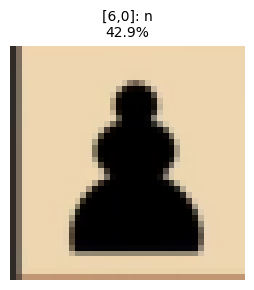

In [12]:
# Detailed analysis of the mistake
test_image_path = 'data/screenshots/chess_2.png'  # or whichever one had the error

# Process and predict
squares = process_image_with_preprocessing(test_image_path, use_preprocessing=False)
predictions = ensemble_model.predict(squares, verbose=0)

# Get predictions with confidence
predicted_classes = predictions.argmax(axis=1)
confidences = (predictions.max(axis=1) / 3) * 100  # Convert to percentage

# Show low confidence predictions
print("Predictions with confidence < 95%:")
print("="*60)
for i, (pred_class, conf) in enumerate(zip(predicted_classes, confidences)):
    if conf < 95:
        row = i // 8
        col = i % 8
        piece_name = piece_symbols[pred_class] if pred_class < 12 else 'empty'
        print(f"Square [{row},{col}]: Predicted '{piece_name}' with {conf:.1f}% confidence")

# Visualize the actual squares where model was uncertain
print("\nShowing squares where confidence < 90%:")
uncertain_indices = [i for i, conf in enumerate(confidences) if conf < 90]

if len(uncertain_indices) > 0:
    fig, axes = plt.subplots(1, min(len(uncertain_indices), 5), figsize=(15, 3))
    if len(uncertain_indices) == 1:
        axes = [axes]
    
    for idx, square_idx in enumerate(uncertain_indices[:5]):
        axes[idx].imshow(squares[square_idx])
        row = square_idx // 8
        col = square_idx % 8
        pred = piece_symbols[predicted_classes[square_idx]] if predicted_classes[square_idx] < 12 else 'empty'
        axes[idx].set_title(f"[{row},{col}]: {pred}\n{confidences[square_idx]:.1f}%", fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No uncertain predictions!")

## Step 11: Interactive Testing

Test any specific image by providing the path.

In [ ]:
# Change this to test a specific image
CUSTOM_IMAGE_PATH = 'data/screenshots/your_image.png'  # Update this path

# Set to True to test custom image
TEST_CUSTOM_IMAGE = False

if TEST_CUSTOM_IMAGE:
    if os.path.exists(CUSTOM_IMAGE_PATH):
        print(f"Testing: {CUSTOM_IMAGE_PATH}")
        
        # Load and display
        img = io.imread(CUSTOM_IMAGE_PATH)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Custom Test Image")
        plt.show()
        
        # Process and predict
        squares = process_image_with_preprocessing(CUSTOM_IMAGE_PATH, use_preprocessing=True)
        predictions = ensemble_model.predict(squares, verbose=0)
        predicted_fen = fen_from_onehot(predictions.argmax(axis=1).reshape(8, 8))
        confidence = (predictions.max(axis=1) / 3).mean()
        
        print(f"\n🎯 Predicted FEN: {predicted_fen}")
        print(f"📊 Confidence: {confidence*100:.2f}%")
        print(f"🔗 Lichess: {create_lichess_link_simple(predicted_fen)}")
    else:
        print(f"❌ File not found: {CUSTOM_IMAGE_PATH}")
else:
    print("ℹ️ Set TEST_CUSTOM_IMAGE = True and update CUSTOM_IMAGE_PATH to test a specific image")

## Summary

### What This Notebook Does:

1. ✅ Loads your trained ensemble model
2. ✅ Preprocesses images to remove arrows/highlights
3. ✅ Enhances contrast for better piece recognition
4. ✅ Tests predictions with and without preprocessing
5. ✅ Generates FEN notation and Lichess links

### Next Steps:

1. **Add more test images** to `data/screenshots/`
2. **Compare results** with Lichess to verify accuracy
3. **Fine-tune preprocessing** if needed (adjust color ranges)
4. **Build the web app** using these functions!

### Notes:

- Preprocessing helps with arrows/highlights but may not fully solve different piece style issues
- For production, you might need to train on more diverse piece sets
- Current model achieves 100% on Kaggle dataset (photorealistic pieces)
- Real-world screenshots may have lower accuracy depending on style